# Panjabi et al. (2001) : Axial rotation and Bending

- Performed by: Yash Niranjan Poojary
- Reviewed by:
- Last modified : 2nd January 2024
- SAFER HBM Version: ![Static Badge](https://img.shields.io/badge/SAFER_HBM-11.0-1?style=flat&logoColor=blue&labelColor=whitw&color=blue)
- LSDYNA version:  `mpp d R12.2.1 `

## Experiment by  Panjabi et al. (2001)

### Summary:

The simulated outputs are compared to the references from PMHS tests reported by  Panjabi et al.  <sup>[1]</sup>
1. Panjabi MM, Crisco JJ, Vasavada A, Oda T, Cholewicki J, Nibu K, Shin E. Mechanical properties of the human cervical spine as shown by three-dimensional load–displacement curves. Spine. 2001 Dec 15;26(24):2692-700.[Article](https://journals.lww.com/spinejournal/Abstract/2001/12150/Mechanical_Properties_of_the_Human_Cervical_Spine.12.aspx)

<!-- ![](../_env/setup_panjabi_s11.png)  -->
```{figure} ../_env/setup_panjabi_s11.png
---
align: center
---
Setup for C4-C5
```

## Experiment
- Testing was performed on 1 C0–C5, 5 C0–C6, 2 C0–C7, and 8 C2–C7 from 16 whole spine specimens.
- simulations were run for one functional spine unit (2 vetebrae segments)
### Information on the subjects/specimens
*Not available*

## Loading and Boundary Conditions
### Boundary Conditions
- `Coordinate system `              : The positive y axis isdirected superiorly, and the positive z axis is oriented anteriorly. The positive x axis is directed to the left and perpendicular to the sagittal plane
> **Setup**
> - ***Load case***                     : flexion , extension, left axial rotation, right axial rotation, right lateral bending, and left lateral bending
> - ***Potting Cups***                  :Cylinder with $\phi=100mm, height=35mm$ polyester resin $E=0.92Gpa, density=1.43g/cm^3, pr=0.44$ modelled with `MAT_1`
>
> **Constraints and Loading** 
> - ***Loading***            : quasistatic loading until maximum reaches 1Nm
> - ***Constraint***           :  
>   * The occiput and the caudal-most vertebra were mounted in polyester resin casts usning `CONSTRAINT_SHELL_IN_SOLID_PENALTY`
>   * `*BOUNDARY_PRESCRIBED_MOTION_RIGID` to fix the bottom pot and measure the raction forces and moments. In the upper potting all the directions other than the loaded direction was fixed.
> - ***Loading Constraint***           : `*BOUNDARY_PRESCRIBED_MOTION_RIGID` to prescribe pure moments in flexion/extension.

### Responses recorded
- Force measured usig a 6 axis loadcell at the bottom potting
-  Angular displacement at the applied boundary condition

The reference values from the paper were digitalised and are incuded in the notebook. The data corresponds to the unnormalised corridors.


In [4]:
import os
import glob
# for data analysis
import pandas as pd # Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:

# Plot formats
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1)
s11 = {"linestyle" :'-', "color" : 'b',"alpha" :1,"linewidth":2}
pmhs = {"linestyle" :'--', "color" : 'k',"alpha" :0.7,"linewidth":1}
test_plot = { 'linestyle':'-', 'marker':'s', 'color':'k', 'linewidth' : 1,'alpha':0.5}
pmhsM = {"linestyle" :'--', "color" : 'b',"alpha" :0.7,"linewidth":1}
pmhsF = {"linestyle" :'--', "color" : 'r',"alpha" : 0.7,"linewidth":1}
Test_avg = {"linestyle" :'-', "color" : 'k',"alpha" :1,"linewidth":1, 'marker' :"o", 'markevery': 75}
test_corr = {"color": 'silver',"alpha" : 0.7,'linewidth':0.0}
Test_avg_norm = {"linestyle" :'-', "color" : 'k',"alpha" :1,"linewidth":1, 'marker' :"o", 'markevery': 75,'mfc': 'seagreen','mec': 'seagreen'}

# Dataframe formats
def select_col(x):
    mask = x['Overall Score'] <0.5
    df1 =  pd.DataFrame('', index=x.index, columns=x.columns)
    df1.loc[mask,'Overall Score'] = 'color:crimson;font-weight:bold;'
    return df1
heading = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("font-weight", "bold")])]
content={'text-align': 'center'}

In [6]:
Loadcase=["flexion","extension","axial_rotation_L","axial_rotation_R","lateral_bending_L","lateral_bending_R"]
Tests=["C0_C1","C1_C2","C2_C3","C3_C4","C4_C5","C5_C6","C6_C7"]

figures_dir = "../data/processed/SAFER_11.0/figures/"
processed_data_dir = f"../data/processed/SAFER_11.0"
experiment_dir= "../data/experiment_data/"
binout_path_sim={}
result_output_dir={}

if not os.path.exists(processed_data_dir): 
    os.makedirs(processed_data_dir)
if not os.path.exists(figures_dir): 
    os.makedirs(figures_dir)


## Postprocessing with dynasaur

In [7]:
# Import the dynasaur library
from dynasaur.plugins.data_visualization_controller import DataVisualizationController

In [8]:
# Path to Dynasaur definition files

# Dynasaur object definitions
dynasaur_ids = ["../_env/id.def"]

# Dynasaur calculation definitions
dynasaur_calculation_defs = [ "../_env/post_FE.def" ,"../_env/post_Ax.def", "../_env/post_LB.def","../../model/SAFER_11.0/postprocessing/01_energy_calculation.def"]

## Extracting Time Series 

In [9]:
sim_output={}
for case in Loadcase:
    if not os.path.exists(processed_data_dir): 
        os.makedirs(processed_data_dir)
    if not os.path.exists(figures_dir): 
        os.makedirs(figures_dir)
    for test in Tests:
        binout_path_sim[test] = "{}/{}".format(case,test)
        result_output_dir[test] = os.path.join(processed_data_dir, binout_path_sim[test])
        if not os.path.exists(result_output_dir[test]): 
            os.makedirs(result_output_dir[test])
    for test in Tests:
        sim = DataVisualizationController(calculation_procedure_def_file=dynasaur_calculation_defs,
                                                    object_def_file=dynasaur_ids,
                                                    data_source= binout_path_sim[test] +'/binout*')
        commands = sim.get_defined_calculation_procedures()
        print(commands)
        for command in sim.get_defined_calculation_procedures():
            sim.calculate(command)
        # export post-processed data
        sim.write_CSV(result_output_dir[test], filename="Dynasaur_output.csv")
        # Import processed data
        sim_output[case,test]=pd.read_csv(os.path.join(result_output_dir[test],"Dynasaur_output.csv"), delimiter=';', na_values='-', header = [0,1,2,3])

[READ DYNASAUR DEF]	read ../_env/post_FE.def
[READ DYNASAUR DEF]	read ../_env/post_Ax.def
[READ DYNASAUR DEF]	read ../_env/post_LB.def
[READ DYNASAUR DEF]	read ../../model/SAFER_11.0/postprocessing/01_energy_calculation.def
[READ DYNASAUR DEF]	done
[READ DYNASAUR DEF]	read ../_env/id.def
[READ DYNASAUR DEF]	done
[READ BINOUT]	read rbdout data ...
[READ BINOUT]	done reading rbdout!
[READ BINOUT]	read bndout data ...
[READ BINOUT]	done reading bndout!
[READ BINOUT]	read glstat data ...
[READ BINOUT]	done reading glstat!
[{'visualization': 'Potting_Rot_y', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Potting_Mom_y', 'x_label': 'time', 'y_label': 'moment'}, {'visualization': 'Potting_Rot_z', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Potting_Mom_z', 'x_label': 'time', 'y_label': 'moment'}, {'visualization': 'Potting_Rot_x', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Potting_Mom_x', 'x_label': 'time', 'y_label': 'moment'}, {'visualization': 'MOD

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

c:\Users\yash\Anaconda3\envs\SOT\lib\site-packages\dynasaur\calc\cfc.py:66: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sampled_array = np.array(sampled_array)


[CALCULATION]	Calculating Visualization: Potting_Mom_y
[DATA]	read id 4300001 from channel name: ymoment
[CALCULATION]	Calculating Visualization: Potting_Rot_z
[DATA]	read id 4300001 from channel name: global_rdz
[CALCULATION]	Calculating Visualization: Potting_Mom_z
[DATA]	read id 4300001 from channel name: zmoment
[CALCULATION]	Calculating Visualization: Potting_Rot_x
[DATA]	read id 4300001 from channel name: global_rdx
[CALCULATION]	Calculating Visualization: Potting_Mom_x
[DATA]	read id 4300001 from channel name: xmoment
[CALCULATION]	Calculating Visualization: MODEL_Added_Mass
[DATA]	ENERGY_GLOBAL read from channel name: added_mass
[CALCULATION]	Calculating Visualization: MODEL_Total_Energy
[DATA]	ENERGY_GLOBAL read from channel name: total_energy
[CALCULATION]	Calculating Visualization: MODEL_Internal_Energy
[DATA]	ENERGY_GLOBAL read from channel name: internal_energy
[CALCULATION]	Calculating Visualization: MODEL_Kinetic_Energy
[DATA]	ENERGY_GLOBAL read from channel name: kineti

In [10]:
flex_ext_test=pd.read_csv(os.path.join(experiment_dir,'flexion-extension.csv'),delimiter=';',header=[0,1])
axial_test=pd.read_csv(os.path.join(experiment_dir,'axial_rotation.csv'),delimiter=';',header=[0,1])
lateral_test=pd.read_csv(os.path.join(experiment_dir,'lateral_bending.csv'),delimiter=';',header=[0,1])

## Flexion-Extension Range of motion of spine units
- C1C2 transverse ligament resists flexion.

In [12]:
df_v11={}
for case in Loadcase:
    path_case_11=os.path.join("../data/processed/SAFER_11.0",case)
    for test in Tests:
        df_v11[case,test]=pd.read_csv(os.path.join(os.path.join(path_case_11,test),"Dynasaur_output.csv")
                                          , delimiter=';', na_values='-', header = [0,1,2,3])

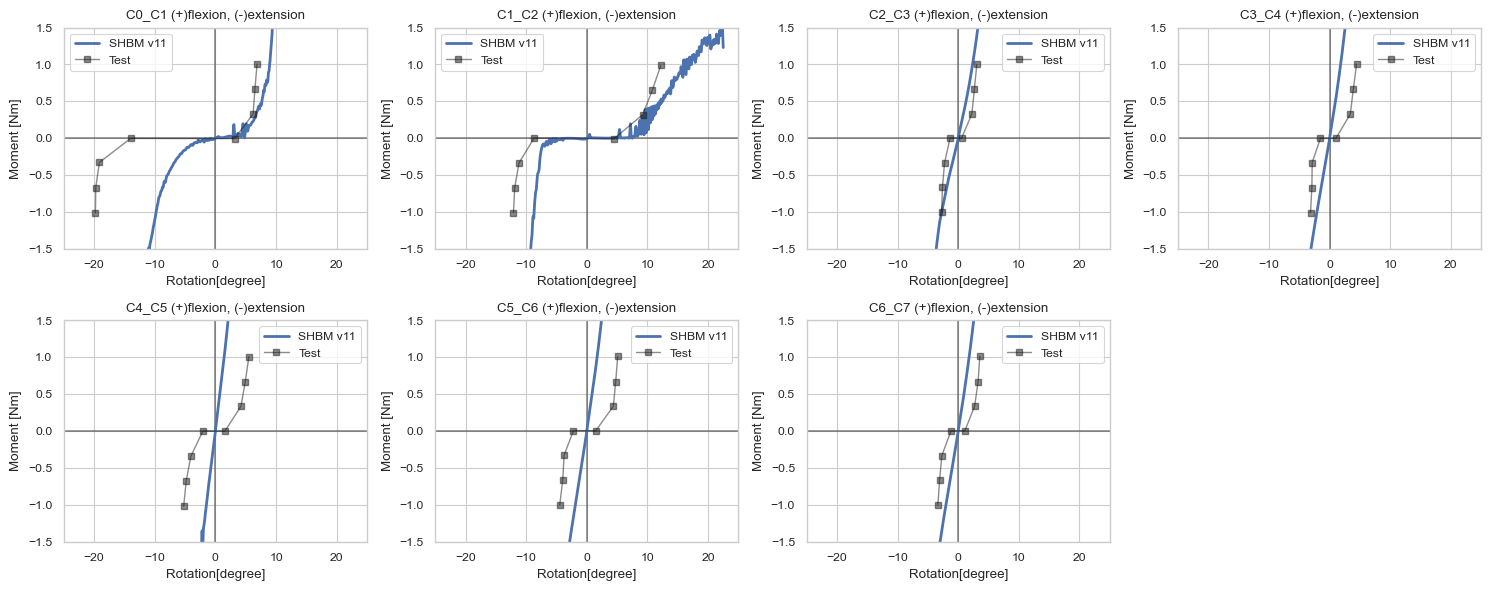

In [13]:
fig_fxex, ax = plt.subplots(nrows=2, ncols=4,figsize=(15, 6))
m=0
for axl in ax.flat:
    if m == 7:
        fig_fxex.delaxes(axl)
        break;
    axl.hlines(y=0, xmin=-300, xmax=300, color='k',alpha=0.5)
    axl.vlines(x=0, ymin=-300, ymax=300, color='k',alpha=0.5)
    axl.set_xlabel('Rotation[degree]');
    axl.set_ylabel('Moment [Nm]');
    axl.set_title('{} {}'.format(Tests[m],'(+)flexion, (-)extension'))
    axl.set_ylim([-1.5,1.5]);
    axl.set_xlim([-25,25]);
    axl.plot(np.degrees(pd.DataFrame(sim_output['flexion',Tests[m]].Potting.Rot_y.angle))
               ,pd.DataFrame(sim_output['flexion',Tests[m]].Potting.Mom_y.moment),**s11,label='SHBM v11')
    
    axl.plot(-np.degrees(pd.DataFrame(sim_output['extension',Tests[m]].Potting.Rot_y.angle))
               ,-pd.DataFrame(sim_output['extension',Tests[m]].Potting.Mom_y.moment),**s11)
    axl.plot(flex_ext_test[flex_ext_test.columns[::2].values[m][0]].R
               ,flex_ext_test[flex_ext_test.columns[::2].values[m][0]].M,**test_plot,label='Test')
    axl.legend()
    m=m+1
fig_fxex.tight_layout()

### Range of motion

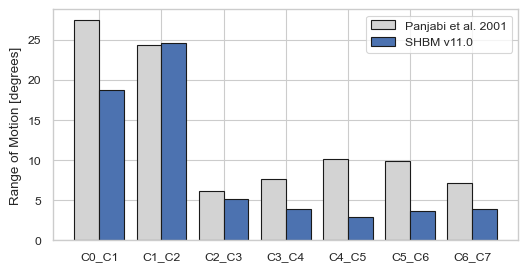

In [14]:
flex_v11=[]
ext_v11=[]
ROM_v11=[]
for m in range(0,7):
    
    index_fl=df_v11['flexion',Tests[m]].Potting.Mom_y.moment[df_v11['flexion',Tests[m]].Potting.Mom_y.moment>=1].dropna().index[0]
    flex_v11.append(np.degrees(df_v11['flexion',Tests[m]].Potting.Rot_y.angle.iloc[index_fl][0]))
    
    index_ex=df_v11['extension',Tests[m]].Potting.Mom_y.moment[df_v11['extension',Tests[m]].Potting.Mom_y.moment>=1].dropna().index[0]
    ext_v11.append(np.degrees(df_v11['extension',Tests[m]].Potting.Rot_y.angle.iloc[index_ex][0]))
    ROM_v11.append(np.degrees(df_v11['flexion',Tests[m]].Potting.Rot_y.angle.iloc[index_fl][0])+np.degrees(df_v11['extension',Tests[m]].Potting.Rot_y.angle.iloc[index_ex][0]))
    
test={'width' : 0.4 ,'color':'lightgray','alpha':1, 'edgecolor':'k'}
S11={'width' : 0.4 ,'color':'b','alpha':1, 'edgecolor':'k'}

ROM_FE_test=[27.4,24.4,6.2,7.7,10.1,9.9,7.1]
fig, ax = plt.subplots(figsize=(6, 3))
br1 = np.arange(len(ROM_FE_test))
ax.bar(br1-0.2,ROM_FE_test,label='Panjabi et al. 2001',**test)
ax.bar(br1+0.2,ROM_v11,label='SHBM v11.0',**S11)
plt.xticks(range(len(ROM_FE_test)), Tests, rotation=0);
plt.legend();
plt.ylabel('Range of Motion [degrees]');


### Energy plots
#### Flexion

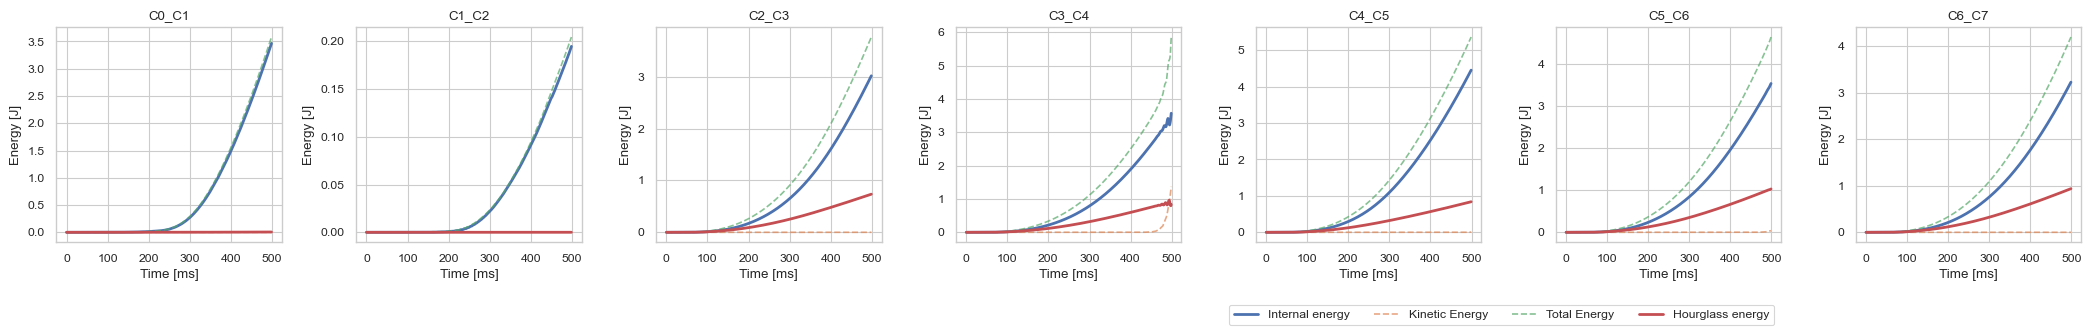

In [20]:
fig_fd, axs = plt.subplots(nrows=1, ncols=7,figsize=(21,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output['flexion',Tests[i]].MODEL.Internal_Energy.time,sim_output['flexion',Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output['flexion',Tests[i]].MODEL.Kinetic_Energy.time,sim_output['flexion',Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['flexion',Tests[i]].MODEL.Total_Energy.time,sim_output['flexion',Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['flexion',Tests[i]].MODEL.Hourglass_Energy.time,sim_output['flexion',Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]')
    i=i+1
fig_fd.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.85,-0.01),ncol=4);
fig_fd.tight_layout()

#### Extension

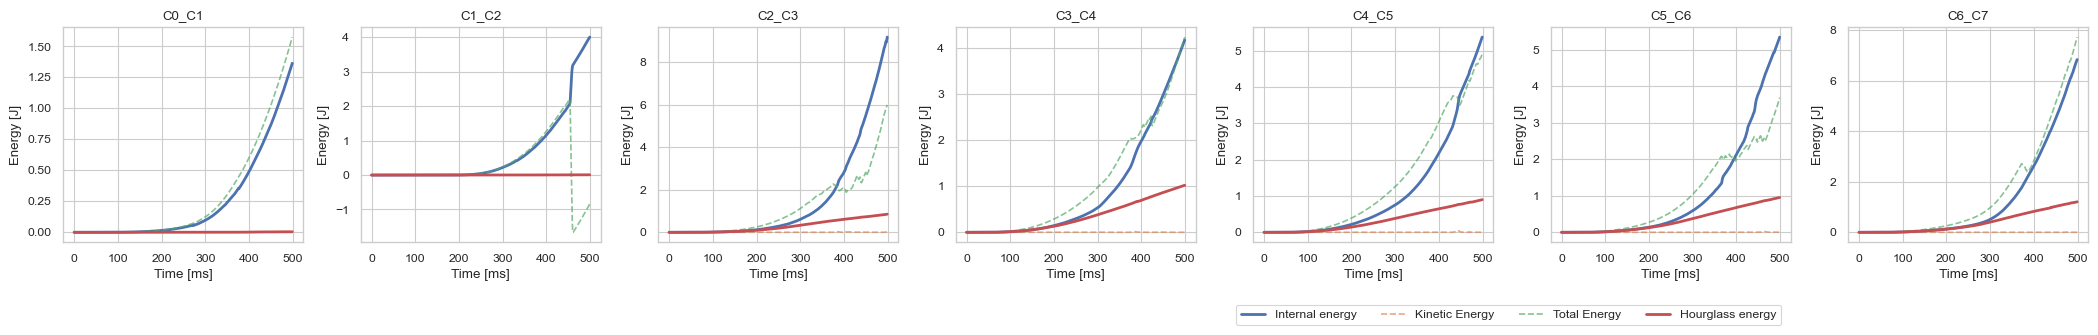

In [23]:
fig_fd, axs = plt.subplots(nrows=1, ncols=7,figsize=(21,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output['extension',Tests[i]].MODEL.Internal_Energy.time,sim_output['extension',Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output['extension',Tests[i]].MODEL.Kinetic_Energy.time,sim_output['extension',Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['extension',Tests[i]].MODEL.Total_Energy.time,sim_output['extension',Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['extension',Tests[i]].MODEL.Hourglass_Energy.time,sim_output['extension',Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]')
    i=i+1
fig_fd.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.85,-0.01),ncol=4);
fig_fd.tight_layout()

## Axial Rotation Range of motion of spine units

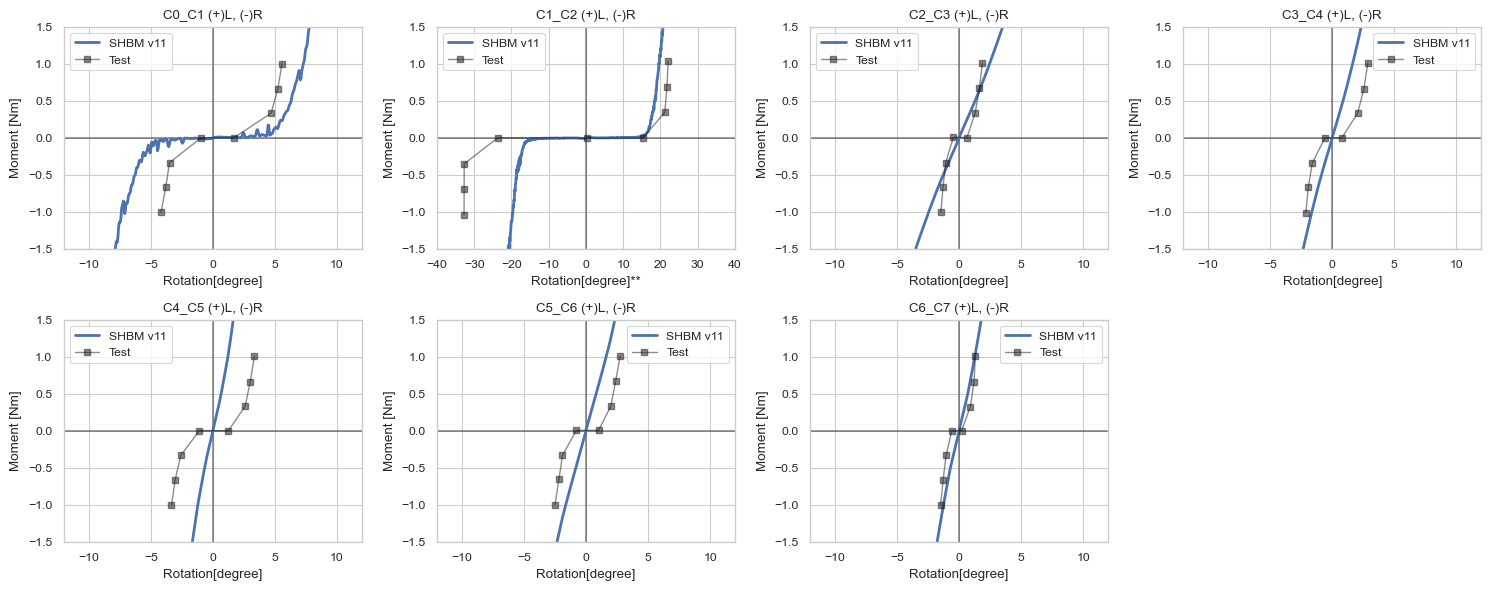

In [30]:
fig_axrot, ax = plt.subplots(nrows=2, ncols=4,figsize=(15, 6))
m=0
for axl in ax.flat:
    if m == 7:
        fig_axrot.delaxes(axl)
        break;
    axl.hlines(y=0, xmin=-300, xmax=300, color='k',alpha=0.5)
    axl.vlines(x=0, ymin=-300, ymax=300, color='k',alpha=0.5)
    
    axl.set_ylabel('Moment [Nm]');
    axl.set_title('{} {}'.format(Tests[m],'(+)L, (-)R'))
    if m==1:
        axl.set_ylim([-1.5,1.5]);
        axl.set_xlim([-40,40]);
        axl.set_xlabel('Rotation[degree]**');
    else:
        axl.set_ylim([-1.5,1.5]);
        axl.set_xlim([-12,12]);
        axl.set_xlabel('Rotation[degree]');
    axl.plot(np.degrees(pd.DataFrame(sim_output['axial_rotation_L',Tests[m]].Potting.Rot_z.angle))
               ,pd.DataFrame(sim_output['axial_rotation_L',Tests[m]].Potting.Mom_z.moment),**s11,label='SHBM v11')
    axl.plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation_R',Tests[m]].Potting.Rot_z.angle))
               ,-pd.DataFrame(sim_output['axial_rotation_R',Tests[m]].Potting.Mom_z.moment),**s11)
    axl.plot(axial_test[axial_test.columns[::2].values[m][0]].R,axial_test[axial_test.columns[::2].values[m][0]].M,**test_plot,label='Test')
    axl.legend()
    m=m+1
# fig_axrot.legend(ncols=3, bbox_to_anchor=(0.6,- 0.01))
fig_axrot.tight_layout()

### Range of motion

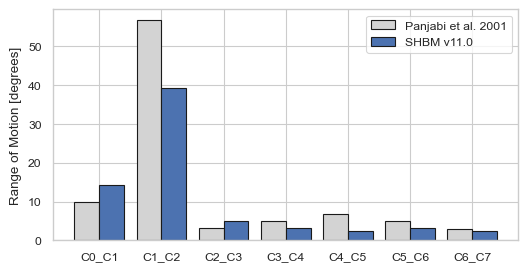

In [23]:
axL_v10=[]
axL_v10=[]
ROM_v10=[]
axR_v11=[]
axR_v11=[]
ROM_v11=[]
for m in range(0,7):
    
    index_fl=df_v11['axial_rotation_L',Tests[m]].Potting.Mom_z.moment[df_v11['axial_rotation_L',Tests[m]].Potting.Mom_z.moment>=1].dropna().index[0]
    axR_v11.append(np.degrees(df_v11['axial_rotation_L',Tests[m]].Potting.Rot_z.angle.iloc[index_fl][0]))
    
    index_ex=df_v11['axial_rotation_R',Tests[m]].Potting.Mom_z.moment[df_v11['axial_rotation_R',Tests[m]].Potting.Mom_z.moment>=1].dropna().index[0]
    axR_v11.append(np.degrees(df_v11['axial_rotation_R',Tests[m]].Potting.Rot_z.angle.iloc[index_ex][0]))
    ROM_v11.append(np.degrees(df_v11['axial_rotation_L',Tests[m]].Potting.Rot_z.angle.iloc[index_fl][0])+np.degrees(df_v11['axial_rotation_R',Tests[m]].Potting.Rot_z.angle.iloc[index_ex][0]))

ROM_Ax_test=[9.9,56.7,3.2,5.1,6.8,5.1,2.9]
fig, ax = plt.subplots(figsize=(6, 3))
br1 = np.arange(len(ROM_Ax_test))
ax.bar(br1-0.2,ROM_Ax_test,label='Panjabi et al. 2001',**test)
ax.bar(br1+0.2,ROM_v11,label='SHBM v11.0',**S11)
plt.xticks(range(len(ROM_Ax_test)), Tests, rotation=0);
plt.legend();
plt.ylabel('Range of Motion [degrees]');


### Energy plots
#### Axial rotation-Right

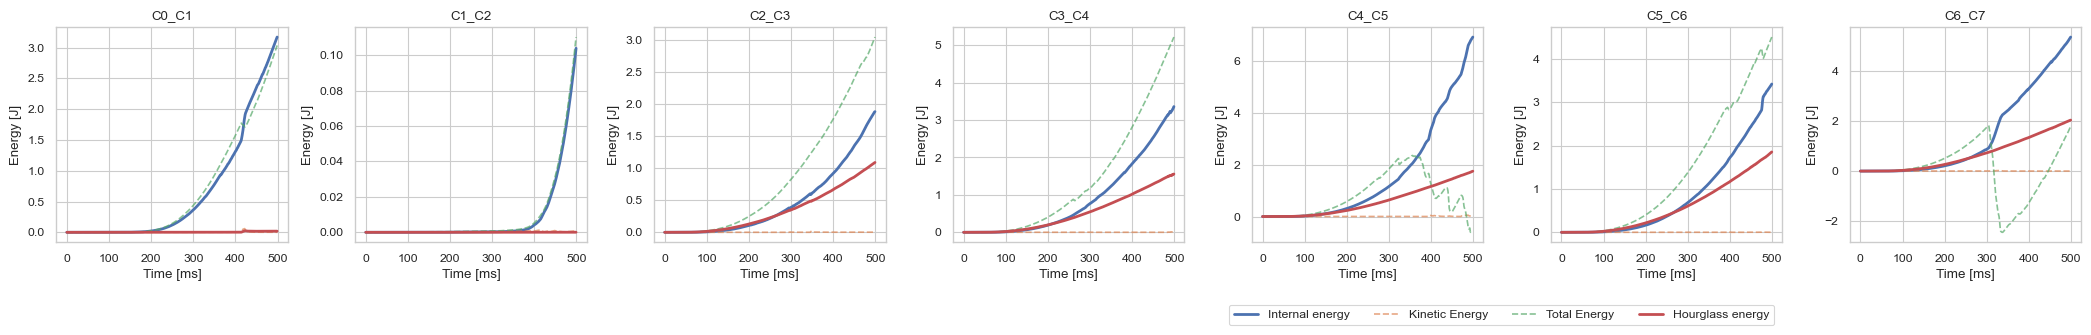

In [24]:
fig_fd, axs = plt.subplots(nrows=1, ncols=7,figsize=(21,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output['axial_rotation_R',Tests[i]].MODEL.Internal_Energy.time,sim_output['axial_rotation_R',Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output['axial_rotation_R',Tests[i]].MODEL.Kinetic_Energy.time,sim_output['axial_rotation_R',Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['axial_rotation_R',Tests[i]].MODEL.Total_Energy.time,sim_output['axial_rotation_R',Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['axial_rotation_R',Tests[i]].MODEL.Hourglass_Energy.time,sim_output['axial_rotation_R',Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]')
    i=i+1
fig_fd.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.85,-0.01),ncol=4);
fig_fd.tight_layout()

#### Axial rotation-Left

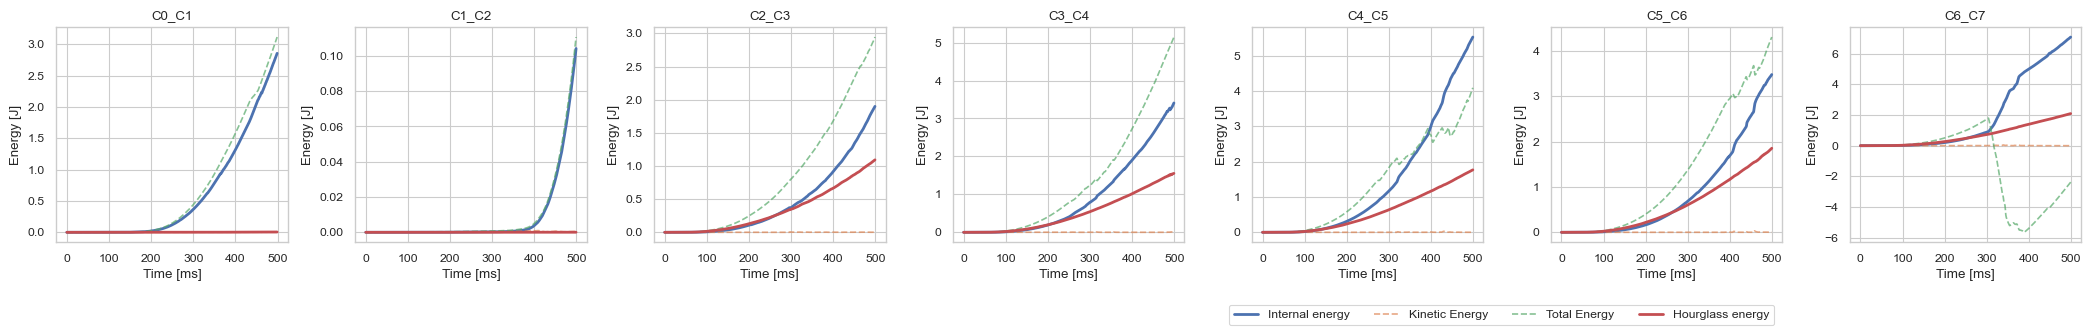

In [25]:
fig_fd, axs = plt.subplots(nrows=1, ncols=7,figsize=(21,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output['axial_rotation_L',Tests[i]].MODEL.Internal_Energy.time,sim_output['axial_rotation_L',Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output['axial_rotation_L',Tests[i]].MODEL.Kinetic_Energy.time,sim_output['axial_rotation_L',Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['axial_rotation_L',Tests[i]].MODEL.Total_Energy.time,sim_output['axial_rotation_L',Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['axial_rotation_L',Tests[i]].MODEL.Hourglass_Energy.time,sim_output['axial_rotation_L',Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]')
    i=i+1
fig_fd.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.85,-0.01),ncol=4);
fig_fd.tight_layout()

## Lateral Bending Range of motion of spine units
- part of alar-ligament retained in C1C2 influence lateral bending.

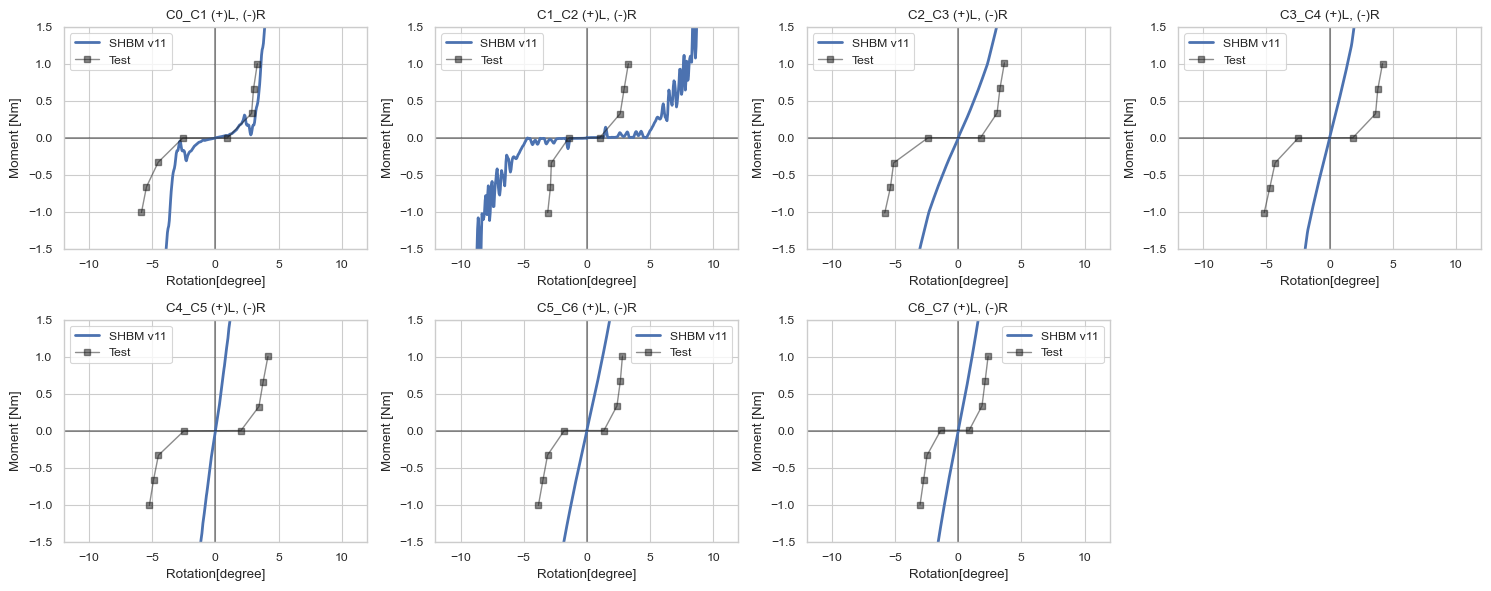

In [26]:
fig_lb, ax = plt.subplots(nrows=2, ncols=4,figsize=(15, 6))
m=0
for axl in ax.flat:
    if m == 7:
        fig_lb.delaxes(axl)
        break;
    axl.hlines(y=0, xmin=-300, xmax=300, color='k',alpha=0.5)
    axl.vlines(x=0, ymin=-300, ymax=300, color='k',alpha=0.5)
    axl.set_xlabel('Rotation[degree]');
    axl.set_ylabel('Moment [Nm]');
    axl.set_title('{} {}'.format(Tests[m],'(+)L, (-)R'))
    axl.set_ylim([-1.5,1.5]);
    axl.set_xlim([-12,12]);

    axl.plot(np.degrees(pd.DataFrame(sim_output['lateral_bending_L',Tests[m]].Potting.Rot_x.angle)),
               pd.DataFrame(sim_output['lateral_bending_L',Tests[m]].Potting.Mom_x.moment),**s11,label='SHBM v11')
    axl.plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending_R',Tests[m]].Potting.Rot_x.angle)),
               -pd.DataFrame(sim_output['lateral_bending_R',Tests[m]].Potting.Mom_x.moment),**s11)
    axl.plot(lateral_test[lateral_test.columns[::2].values[m][0]].R,lateral_test[lateral_test.columns[::2].values[m][0]].M,**test_plot,label='Test')
    axl.legend()
    m=m+1
fig_lb.tight_layout()

### Range of motion

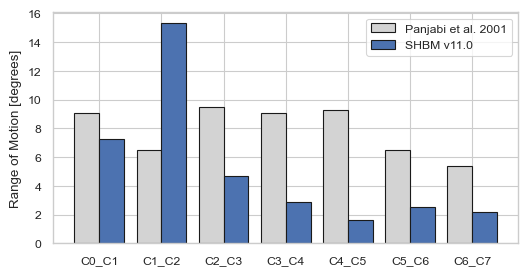

In [25]:
lbR_v11=[]
lbR_v11=[]
ROM_v11=[]
for m in range(0,7):
    
    index_fl=df_v11['lateral_bending_R',Tests[m]].Potting.Mom_x.moment[df_v11['lateral_bending_R',Tests[m]].Potting.Mom_x.moment>=1].dropna().index[0]
    lbR_v11.append(np.degrees(df_v11['lateral_bending_R',Tests[m]].Potting.Rot_x.angle.iloc[index_fl][0]))
    
    index_ex=df_v11['lateral_bending_R',Tests[m]].Potting.Mom_x.moment[df_v11['lateral_bending_R',Tests[m]].Potting.Mom_x.moment>=1].dropna().index[0]
    lbR_v11.append(np.degrees(df_v11['lateral_bending_R',Tests[m]].Potting.Rot_x.angle.iloc[index_ex][0]))
    ROM_v11.append(np.degrees(df_v11['lateral_bending_R',Tests[m]].Potting.Rot_x.angle.iloc[index_fl][0])+np.degrees(df_v11['lateral_bending_R',Tests[m]].Potting.Rot_x.angle.iloc[index_ex][0]))

ROM_lb_test=[9.1,6.5,9.5,9.1,9.3,6.5,5.4]
fig, ax = plt.subplots(figsize=(6, 3))
br1 = np.arange(len(ROM_lb_test))
ax.bar(br1-0.2,ROM_lb_test,label='Panjabi et al. 2001',**test)
ax.bar(br1+0.2,ROM_v11,label='SHBM v11.0',**S11)
plt.xticks(range(len(ROM_lb_test)), Tests, rotation=0);
plt.legend();
plt.ylabel('Range of Motion [degrees]');


### Energy plots
#### Lateral bending-Right

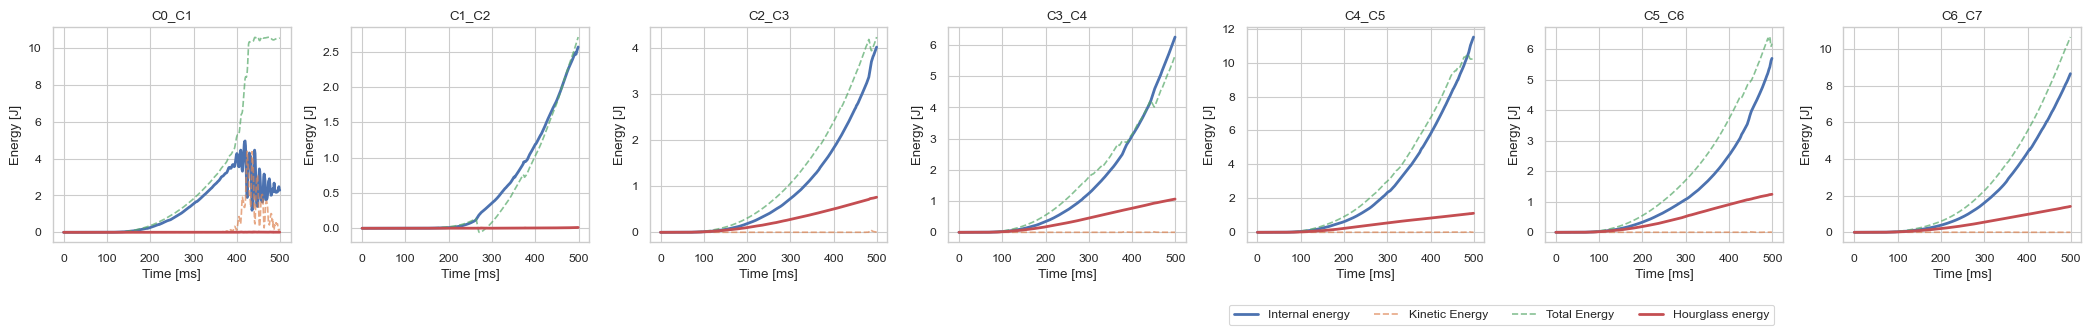

In [27]:
fig_fd, axs = plt.subplots(nrows=1, ncols=7,figsize=(21,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output['lateral_bending_R',Tests[i]].MODEL.Internal_Energy.time,sim_output['lateral_bending_R',Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output['lateral_bending_R',Tests[i]].MODEL.Kinetic_Energy.time,sim_output['lateral_bending_R',Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['lateral_bending_R',Tests[i]].MODEL.Total_Energy.time,sim_output['lateral_bending_R',Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['lateral_bending_R',Tests[i]].MODEL.Hourglass_Energy.time,sim_output['lateral_bending_R',Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]')
    i=i+1
fig_fd.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.85,-0.01),ncol=4);
fig_fd.tight_layout()

#### Lateral bending-Left

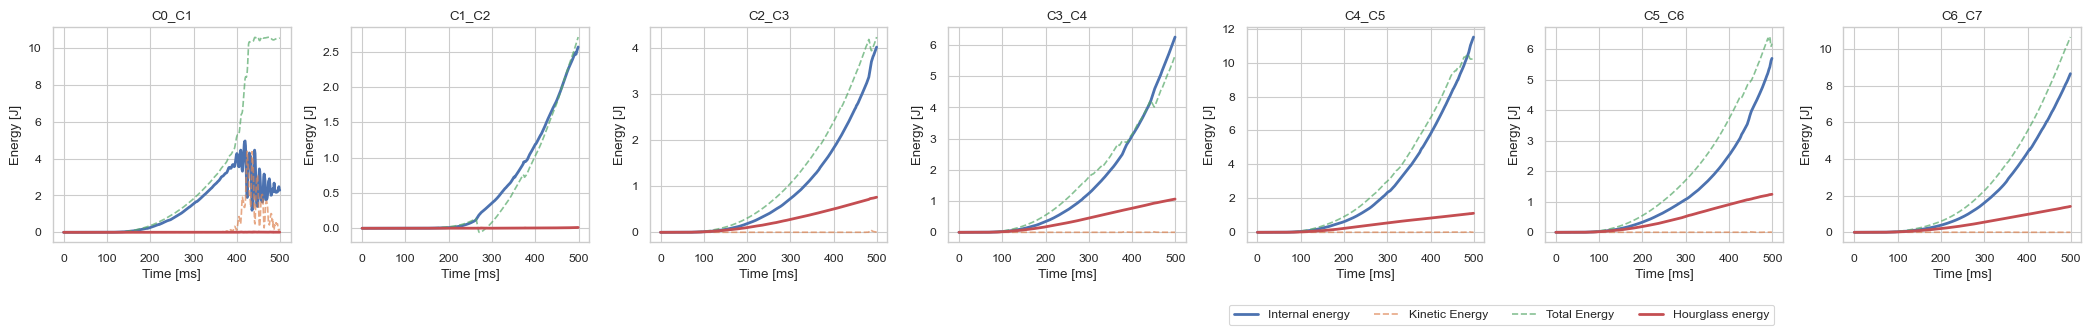

In [28]:
fig_fd, axs = plt.subplots(nrows=1, ncols=7,figsize=(21,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output['lateral_bending_L',Tests[i]].MODEL.Internal_Energy.time,sim_output['lateral_bending_L',Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output['lateral_bending_L',Tests[i]].MODEL.Kinetic_Energy.time,sim_output['lateral_bending_L',Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['lateral_bending_L',Tests[i]].MODEL.Total_Energy.time,sim_output['lateral_bending_L',Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output['lateral_bending_L',Tests[i]].MODEL.Hourglass_Energy.time,sim_output['lateral_bending_L',Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]')
    i=i+1
fig_fd.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.85,-0.01),ncol=4);
fig_fd.tight_layout()